## Word Lists and Sentiment Analysis



A traditional method of analyzing texts is to compute the proportion of the words have positive connotations, negative connotations or are neutral. This method is commonly referred to as sentiment analysis. The typical approach to sentiment analysis is to see how many words in a text are also in a predefined list of words associated with a sentiment. So "I am having a bad day." might score a "1" on a negative sentiment scale for the presence of "bad" or a .17 because one of six of the words is negative. Some sentiment systems rank words on a scale, so that "terrific" might be a 5 while "fine" scores a 1. 

Some systems go beyond positive and negative. The proprietary LIWC program, for example, extends this to measure dozens of other word attributes, such as "tone", "analytic thinking", and "clout". More generally, these methods can be used whenever you have a list of words, and you want to count their occurrences in a set of texts. They are commonly referred to as "dictionary methods."

This lesson introduces two different dictionaries that are available in Python, AFINN, and Vader. It concludes by showing how to analyze a text corpus for occurrences on any arbitrary word list.

This lesson assumes your computer has an Anaconda Python 3.7 distribution installed.

#### AFINN

[AFINN](http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=6010) is an English word listed developed by Finn Årup Nielsen. Words scores range from minus five (negative) to plus five (positive). The English language dictionary consists of 2,477 coded words.

If this is your first time running this notebook, you may need to install it:

```
%pip install afinn
```

In [1]:
from afinn import Afinn

After importing `Afinn`, you need to set the language, English (`en`), Danish (`da`), or emoticon (`emoticons`). 

In [2]:
afinn = Afinn(language='en')

The `score` method returns the sum of word valence scores for a text string.

In [3]:
afinn.score('Bad day.')

-3.0

In [4]:
afinn.score('Good day.')

3.0

In [5]:
afinn.score('Horrible, bad day.')

-6.0

In all these cases, `afinn` has preprocessed the text by removing the punctuation, converting all the words to lower-case, and before analyzing it. 

<div class="alert alert-info">
<h3>Your turn</h3>
<p>Create a sentence with a score of +10 or greater and one of -10 or lower.</div>




### Behind the scenes

 Before using a sentiment dictionary, it is useful to see whether it has any face validity.  To do that, we can look at a sample of the words from the list.

After importing the pandas library, the cell below will load word list as a pandas dataframe from the tab-delimited version on Afinn's GitHub page and display a sample of 10 words.

In [6]:
import pandas as pd

afinn_wl_url = ('https://raw.githubusercontent.com'
                '/fnielsen/afinn/master/afinn/data/AFINN-111.txt')

afinn_wl_df = pd.read_csv(afinn_wl_url, 
                          header=None, # no column names
                          sep='\t',  # tab sepeated
                          names=['term', 'value']) #new column names

seed = 808 # seed for sample so results are stable
afinn_wl_df.sample(10, random_state = seed)

,term,value
1852,regret,-2
1285,indifferent,-2
681,disappoints,-2
770,doubts,-1
1644,outmaneuvered,-2
55,admit,-1
1133,haha,3
1160,haunt,-1
2435,wishing,1
21,abused,-3


We can get a sense of the distribution of word values by plotting them:

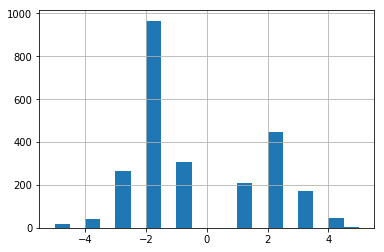

In [7]:
%matplotlib inline

afinn_wl_df['value'].hist(bins=20)

Overall, the dictionary appears to have more negative words than positive words, but the values for both positive and negative words are rarely extreme, with both two and negative two as the most common values.

## Applying the dictionary

We can use Afinn to analyze a more extensive text database.  Aashita Kesarwani put together a [corpus](https://www.kaggle.com/aashita/nyt-comments/home) of comments made to New York Times articles. I sampled 10,000 of these from April 2017 and stored them as a JSON file.


In [8]:
# json_url = ('https://github.com/nealcaren/kuleuvenbigdata/'
#            'blob/master/notebooks/data/nyt_201704_comments.json?raw=true')

json_url = 'data/nyt_201704_comments.json'
nyt_df = pd.read_json(json_url)

The `head` method provides an overview of the dataframe.

In [9]:
nyt_df.head()

,articleID,commentBody,commentID,commentType,createDate,editorsSelection,recommendations,replyCount,sectionName,userDisplayName,userID,userLocation
0,58ef8bfc7c459f24986da097,"Tragedies abound in war, precision munitions n...",22148699,comment,1492123756,False,1,0,Middle East,Bill Owens,66371869,Essex
1,58e5a1507c459f24986d8a56,"""...but then again, please get off my lawn"" ma...",22053980,comment,1491481436,False,6,0,Unknown,Mike P,56758055,Long Island
2,58ff102d7c459f24986dbe81,Just another flim-flam plan to shuffle mor...,22263548,comment,1493128804,False,13,1,Politics,giniajim,1651431,VA
3,58ec83fb7c459f24986d98cd,"What do you mean, nice try? Moynihan Station ...",22113999,userReply,1491924651,False,1,0,Unknown,Guy Walker,55823171,New York City
4,58fcbc357c459f24986db9d0,"Where I live, in a city where cabs are plentif...",22247141,comment,1492971817,True,124,6,Unknown,plphillips,18764882,Washington DC


The column of interest is *commentBody.* 

To estimate the Afinn sentiment score for all of the responses in the dataframe, we can `apply` the scorer to the commentBody column to create a new column. Applying this function takes a couple of seconds.

In [10]:
nyt_df['afinn_score'] = nyt_df['commentBody'].apply(afinn.score)

`describe` gives a sense of the distribution. 

In [11]:
nyt_df['afinn_score'].describe()

count    10000.000000
mean        -0.283000
std          7.166188
min       -130.000000
25%         -3.000000
50%          0.000000
75%          3.000000
max         42.000000
Name: afinn_score, dtype: float64

It is also useful to sort by `afinn_score` to get a sense of what is in the extreme scoring comments. In this case, I subset the dataframe to display just the two relevant columns. 

In [12]:
columns_to_display = ['commentBody', 'afinn_score']

nyt_df.sort_values(by='afinn_score')[columns_to_display].head(10)

,commentBody,afinn_score
9348,"Well Bill, nobody will be able to say that you...",-130.0
5893,"""Don’t Weaken Title IX Campus Sex Assault Poli...",-62.0
1510,Would you describe (former prime minister of I...,-54.0
3378,"""I disapprove of what you say, but I will defe...",-54.0
3956,The ultimate weakness of violence is that it i...,-52.0
9353,The “Dirty Muslim”\n\nShe is called a “Dirty M...,-46.0
7788,Democracy and western civilization are doing j...,-43.0
4446,Immigrants\n\nImmigration purge\nEverybody is...,-42.0
80,"Factual error: There has been no ""rapid fallof...",-42.0
7571,"This is all fine and dandy, except for the fac...",-39.0


It could be useful to see more of the comment.

In [13]:
pd.set_option('max_colwidth', 100)

In [14]:
nyt_df.sort_values(by='afinn_score')[columns_to_display].head(10)

,commentBody,afinn_score
9348,"Well Bill, nobody will be able to say that you and the New York Times didn't warn us. And warn u...",-130.0
5893,"""Don’t Weaken Title IX Campus Sex Assault Policies""\nEveryone deserves to feel safe on campus an...",-62.0
1510,Would you describe (former prime minister of Israel) Menachem Begin as a terrorist? \n\nHere's p...,-54.0
3378,"""I disapprove of what you say, but I will defend to the death your right to say it."" ATTENTION d...",-54.0
3956,"The ultimate weakness of violence is that it is a descending spiral, begetting the very thing it...",-52.0
9353,The “Dirty Muslim”\n\nShe is called a “Dirty Muslim”\nThe“Dirty Muslim” turned away in front of ...,-46.0
7788,"Democracy and western civilization are doing just fine, but have temporarily lost their sea legs...",-43.0
4446,Immigrants\n\nImmigration purge\nEverybody is afraid.\nImmigrants fear law enforcement\nFear un...,-42.0
80,"Factual error: There has been no ""rapid falloff of illegal crossings"" since Trump assumed office...",-42.0
7571,"This is all fine and dandy, except for the fact that these people made hundreds of millions of d...",-39.0


In [15]:
sample = nyt_df.iloc[3956]['commentBody']
print(sample)

The ultimate weakness of violence is that it is a descending spiral, begetting the very thing it seeks to destroy. Instead of diminishing evil, it multiplies it. Through violence you may murder the liar, but you cannot murder the lie, nor establish the truth. Through violence you murder the hater, but you do not murder hate. In fact, violence merely increases hate ... Returning violence for violence multiples violence, adding deeper darkness to a night already devoid of stars. Darkness cannot drive out darkness; only light can do that. 

~ Martin Luther King


By default, the sort is ascending, mean the lowest scoring, or most negative comments, are displayed by `head`. The comments with the highest score are shown with `tail`. 

In [16]:
nyt_df.sort_values(by='afinn_score')[columns_to_display].tail(10)

,commentBody,afinn_score
4949,"Aside from the question of whether positive thinking works, there is a personal philosophical co...",32.0
3617,I found myself immensely enjoying this when I went to see it. I was a big fan of the animated fi...,33.0
7912,How is prepping for the SATs gaming the system? If you as you so subtly imply aced the SATs the ...,34.0
6085,"""'You Create That Chemistry': How Actors Fall in Instant Love\n\nActors are everywhere in the cu...",35.0
3971,"I'd like to see the discussion moved up a level. I my view, in exchange for a corp. charter, we...",37.0
2523,His lawyers are grasping at straws.... In the history of art I'm willing to bet one cannot find ...,38.0
3486,I applaud the spirit of this column and agree one should approach politics with compassion for o...,38.0
8495,"My goodness... This hit home for me in so many ways. I was (am) a Tomboy, who has grown into a s...",39.0
9717,"When I look at the American actresses of Claire Danes generation, it is a shame she ended up on ...",41.0
9205,"""Driven | 2017 Porsche 911 Turbo S""\n\n Since I was born my Favorite thing to do is watch anyth...",42.0


In [17]:
sample = nyt_df.iloc[3486]['commentBody']
print(sample)

I applaud the spirit of this column and agree one should approach politics with compassion for others with differing points of view -- a) because they may have little choice, given their life story, to believe what they believe; and b) they may be right.

There is of course a compassionate center-right vision not comfortable with PC or identity politics (of any color or gender) that believes amping up tensions between groups is not a good idea, that believes decentralized markets will solve problems like healthcare in a much more humane way (by better saturating the distribution).

These people might also oppose the attacks on free speech and due process on today's campus, the use of the govt to surveil people, and the way the media often sides in Orwellian fashion with whatever the statist vision is.

These people are eminently sane and favor a longer-road humanism that results in a sustainable society with greater law and order (where people of all races can flourish in peace on calm

One of the drawbacks to using the raw Afinn score is the that longer texts may yield higher values simply because they contain more words. To adjust for that, we can divide the score by the number of words in the text. 

The most straightforward way to count words in a Python string is to use the `split` method, which splits a string based on white spaces, and then count the length of the resulting list.

In [18]:
def word_count(text_string):
    '''Calculate the number of words in a string'''
    return len(text_string.split())

In [19]:
word_count('This sentence has seven words in it.')

7

You can employ that function on our dataframe to create a new column, `word_count` using `appply` to the text column, `commentBody`.

In [20]:
nyt_df['word_count'] = nyt_df['commentBody'].apply(word_count)

In [21]:
nyt_df['word_count'].describe()

count    10000.000000
mean        73.459700
std         63.508284
min          2.000000
25%         26.000000
50%         53.000000
75%        100.000000
max        296.000000
Name: word_count, dtype: float64

We can divide the original score by the word count to produce `afinn_adjusted`. This isn't exactly a percentage variable, since word scores in Afinn can range from -5 to 5, but it is a useful adjustment to control for variable comment length. To make it clearer that this isn't a percent score, and to make the results more readable, the adjustment is multiplied by 100.

In [22]:
nyt_df['afinn_adjusted'] = nyt_df['afinn_score'] / nyt_df['word_count'] * 100

In [23]:
nyt_df['afinn_adjusted'].describe()

count    10000.000000
mean         0.216934
std         14.222974
min       -100.000000
25%         -6.000000
50%          0.000000
75%          5.882353
max        266.666667
Name: afinn_adjusted, dtype: float64

You can use `groupby` to see how the sentiment score varies by key characteristics, such as whether or not a New York Times editor highlighted the comment.

In [24]:
nyt_df.groupby('editorsSelection')['afinn_adjusted'].describe()

,count,mean,std,min,25%,50%,75%,max
editorsSelection,,,,,,,,
False,9783.0,0.245986,14.302260,-100.000000,-6.000000,0.0,5.882353,266.666667
True,217.0,-1.092828,9.952139,-61.904762,-5.504587,0.0,3.875969,60.000000


The above syntax maybe a little complex to decipher.
* `nyt_df` is the dataframe we want to use;
* `.groupby('editorsSelection')` creates a pandas `groupby` object split by the values of `editorsSelection`;
* `['afinn_adjusted']` is the specific column we want to focus on;
* `.describe()` produces descriptive statistics for each of the groups.

Overall, the findings suggest that editors select comments with more of a negative tone. 

Pandas can also be used to create the absolute value of a variable using the `abs` method. This is useful for exploring to what extent, in this case, editors embrace or avoid comments that are extreme, either positive or negative.

In [25]:
nyt_df['afinn_adjusted_abs'] = nyt_df['afinn_adjusted'].abs()

In [26]:
nyt_df.groupby('editorsSelection')['afinn_adjusted_abs'].describe()

,count,mean,std,min,25%,50%,75%,max
editorsSelection,,,,,,,,
False,9783.0,8.930247,11.173974,0.0,2.301499,5.960265,11.721444,266.666667
True,217.0,6.399846,7.687472,0.0,1.612903,4.562738,8.724832,61.904762


Here, there seems to be some evidence that editors are avoiding comments with extreme sentiment, as values are lower across the board for the editor's selections. 

<div class="alert alert-info">
<h3>Your turn</h3>
<p>Group project. Make a histogram of the sentiment of Donald Trump's general election speeches.</div>



#### Vader

A second method for sentiment analysis is [vader](https://github.com/cjhutto/vaderSentiment)(Valence Aware Dictionary and sEntiment Reasoner). According to the authors, it is, "a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media." 

As with Afinn, Vader measures both the strength and direction of sentiment. Based on the work of 10 coders, the Vader dictionary includes approximately 7,500 words, emoticons, emojis, acronyms, and commonly used slang. 

Unlike Afinn, Vader scores an entire text, not just words. Looking at the whole text allows for the algorithm to adjust for negations, such as "not", booster words, such as "remarkably". It also scores words written in all caps as more intense. Vader returns the proportion of a text that is negative, positive, and neutral, along with a combined score. 

There is a version included with nltk (`from nltk.sentiment.vader import SentimentIntensityAnalyzer`) but a more recent version can be separately installed:


```
%pip install vaderSentiment
```


In [30]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Vader requires that you set up an analyzer.

In [31]:
analyzer = SentimentIntensityAnalyzer()

The `polarity_scores` method returns a dictionary with four items. 
* `pos`, `neu`, and `neg`  are the proportions of text that fall in each category.
* `compound` is the normalized, weighted composite score. 

In [32]:
analyzer.polarity_scores('Horrible bad day.')

{'neg': 0.875, 'neu': 0.125, 'pos': 0.0, 'compound': -0.7906}

One useful feature of Vader is that it is able to look at works in context and score appropriately. 

In [33]:
analyzer.polarity_scores("At least it isn't a horrible book.")

{'neg': 0.0, 'neu': 0.637, 'pos': 0.363, 'compound': 0.431}

It also scores contemporary lingo and emojis.

In [34]:
analyzer.polarity_scores('Today SUX!')

{'neg': 0.779, 'neu': 0.221, 'pos': 0.0, 'compound': -0.5461}

In [35]:
analyzer.polarity_scores('💋')

{'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'compound': 0.4215}

<div class="alert alert-info">
<h3>Your turn</h3>
<p>Rerun your positive and negative sentences from before. How do they score now?</div>





Since Vader returns a dictionary (unlike Afinn which returns a single value), it is slightly more complicated to use it on an entire pandas dataframe.

First, apply the analyzer on the text column. 

In [36]:
sentiment = nyt_df['commentBody'].apply(analyzer.polarity_scores)

Our new object `sentiment` is a series, where each item is a dictionary. This series can be unpacked into a dataframe.

In [37]:
sentiment

0         {'neg': 0.576, 'neu': 0.424, 'pos': 0.0, 'compound': -0.7783}
1            {'neg': 0.0, 'neu': 0.85, 'pos': 0.15, 'compound': 0.3182}
2                 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
3       {'neg': 0.069, 'neu': 0.876, 'pos': 0.055, 'compound': -0.5499}
4        {'neg': 0.033, 'neu': 0.836, 'pos': 0.131, 'compound': 0.9107}
5        {'neg': 0.099, 'neu': 0.644, 'pos': 0.258, 'compound': 0.7101}
6       {'neg': 0.104, 'neu': 0.848, 'pos': 0.047, 'compound': -0.8334}
7        {'neg': 0.065, 'neu': 0.794, 'pos': 0.141, 'compound': 0.9588}
8       {'neg': 0.165, 'neu': 0.703, 'pos': 0.132, 'compound': -0.6283}
9                 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
10         {'neg': 0.048, 'neu': 0.883, 'pos': 0.069, 'compound': 0.25}
11         {'neg': 0.0, 'neu': 0.785, 'pos': 0.215, 'compound': 0.9325}
12       {'neg': 0.014, 'neu': 0.877, 'pos': 0.108, 'compound': 0.8622}
13      {'neg': 0.064, 'neu': 0.897, 'pos': 0.039, 'compound': -

In [38]:
sentiment_df = pd.DataFrame(sentiment.tolist())

sentiment_df.head()

,compound,neg,neu,pos
0,-0.7783,0.576,0.424,0.000
1,0.3182,0.000,0.850,0.150
2,0.0000,0.000,1.000,0.000
3,-0.5499,0.069,0.876,0.055
4,0.9107,0.033,0.836,0.131


The new sentiment dataframe can be merged with the original dataframe.

In [39]:
nyt_df_sentiment = pd.concat([nyt_df,sentiment_df], axis = 1)

In [40]:
nyt_df_sentiment.head()

,articleID,commentBody,commentID,commentType,createDate,editorsSelection,recommendations,replyCount,sectionName,userDisplayName,userID,userLocation,afinn_score,word_count,afinn_adjusted,afinn_adjusted_abs,compound,neg,neu,pos
0,58ef8bfc7c459f24986da097,"Tragedies abound in war, precision munitions notwithstanding....",22148699,comment,1492123756,False,1,0,Middle East,Bill Owens,66371869,Essex,-4.0,7,-57.142857,57.142857,-0.7783,0.576,0.424,0.000
1,58e5a1507c459f24986d8a56,"""...but then again, please get off my lawn"" made me spit out my coffee.",22053980,comment,1491481436,False,6,0,Unknown,Mike P,56758055,Long Island,1.0,14,7.142857,7.142857,0.3182,0.000,0.850,0.150
2,58ff102d7c459f24986dbe81,Just another flim-flam plan to shuffle more money to the one percent.,22263548,comment,1493128804,False,13,1,Politics,giniajim,1651431,VA,0.0,12,0.000000,0.000000,0.0000,0.000,1.000,0.000
3,58ec83fb7c459f24986d98cd,"What do you mean, nice try? Moynihan Station is an ongoing project I'm asking the Times to repo...",22113999,userReply,1491924651,False,1,0,Unknown,Guy Walker,55823171,New York City,4.0,104,3.846154,3.846154,-0.5499,0.069,0.876,0.055
4,58fcbc357c459f24986db9d0,"Where I live, in a city where cabs are plentiful, growth has clearly compromised the experience ...",22247141,comment,1492971817,True,124,6,Unknown,plphillips,18764882,Washington DC,8.0,120,6.666667,6.666667,0.9107,0.033,0.836,0.131


If you intend to do this more than once, it can be useful to wrap the entire process into a single function that takes a dataframe and returns the datframe with the polarity columns appended. To clarify where the sentiment information comes from, the prefix `vader_` is added to each of the polarity scores.

In [41]:
def vaderize(df, textfield):
    '''Compute the Vader polarity scores for a textfield. 
    Returns scores and original dataframe.'''

    analyzer = SentimentIntensityAnalyzer()

    print('Estimating polarity scores for %d cases.' % len(df))
    sentiment = df[textfield].apply(analyzer.polarity_scores)

    # convert to dataframe
    sdf = pd.DataFrame(sentiment.tolist()).add_prefix('vader_')

    # merge dataframes
    df_combined = pd.concat([df, sdf], axis=1)
    return df_combined

In [35]:
df_vaderized = vaderize(nyt_df, 'commentBody')

Estimating polarity scores for 10000 cases.


In [36]:
df_vaderized.head()

,articleID,commentBody,commentID,commentType,createDate,editorsSelection,recommendations,replyCount,sectionName,userDisplayName,userID,userLocation,afinn_score,word_count,afinn_adjusted,afinn_adjusted_abs,vader_compound,vader_neg,vader_neu,vader_pos
0,58ef8bfc7c459f24986da097,"Tragedies abound in war, precision munitions n...",22148699,comment,1492123756,False,1,0,Middle East,Bill Owens,66371869,Essex,-4.0,7,-57.142857,57.142857,-0.7783,0.576,0.424,0.000
1,58e5a1507c459f24986d8a56,"""...but then again, please get off my lawn"" ma...",22053980,comment,1491481436,False,6,0,Unknown,Mike P,56758055,Long Island,1.0,14,7.142857,7.142857,0.3182,0.000,0.850,0.150
2,58ff102d7c459f24986dbe81,Just another flim-flam plan to shuffle mor...,22263548,comment,1493128804,False,13,1,Politics,giniajim,1651431,VA,0.0,12,0.000000,0.000000,0.0000,0.000,1.000,0.000
3,58ec83fb7c459f24986d98cd,"What do you mean, nice try? Moynihan Station ...",22113999,userReply,1491924651,False,1,0,Unknown,Guy Walker,55823171,New York City,4.0,104,3.846154,3.846154,-0.5499,0.069,0.876,0.055
4,58fcbc357c459f24986db9d0,"Where I live, in a city where cabs are plentif...",22247141,comment,1492971817,True,124,6,Unknown,plphillips,18764882,Washington DC,8.0,120,6.666667,6.666667,0.9107,0.033,0.836,0.131


The distribution of the combined variable shows peaks at the extremes and zero.

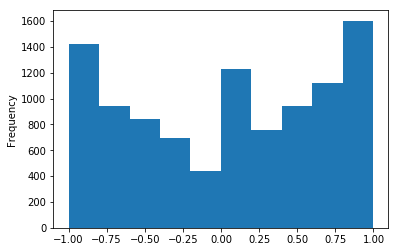

In [37]:
%matplotlib inline


df_vaderized['vader_compound'].plot(kind='hist')



Plotting the positive and negative scores shows that many comments have both attributes present.

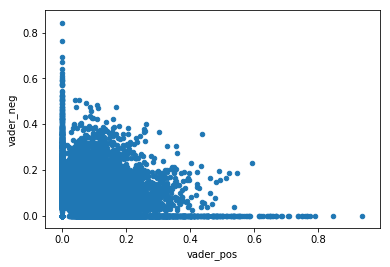

In [38]:
df_vaderized.plot.scatter(x='vader_pos', y = 'vader_neg')

Finally, unlike the Afinn score analysis, there's no strong evidence that the New York Times' editor selection is associated with the Vader sentiment scores.

In [39]:
sentiment_variables = ['afinn_adjusted', 'vader_neg', 'vader_neu', 'vader_pos']

df_vaderized.groupby('editorsSelection')[sentiment_variables].mean()

,afinn_adjusted,vader_neg,vader_neu,vader_pos
editorsSelection,,,,
False,0.245986,0.099534,0.789326,0.111140
True,-1.092828,0.099820,0.792991,0.107161


#### Word List

Occasionally, you will have a sentiment list from a different source that you would like to use. Or, more generally, you have a word list about any subject, not just attitudes, and you want to count their occurrences in texts, such as the use of words associated with politics or hypothesis testing. 

The final section of the lesson shows the steps for building a function that can analyze texts for the presence of words on any given list. In this case, the sample list will be words associated with men that were assembled by [Danielle Sucher](https://github.com/DanielleSucher/Jailbreak-the-Patriarchy). 

The list is stored as a csv file. Pandas can be used to read the word list and turn it into a Python list.

In [40]:
male_words_df = pd.read_csv('data/male_words.csv')
male_words_df.sample(10)

,term
18,uncle
36,sons
31,boy
19,him
9,waiter
32,boys
44,male
33,dude
24,son
26,boyfriends


In [41]:
male_words_list = male_words_df['term'].values

The function that looks for cooccurences has two parts. A preliminary helper function transforms the original text string into a list of lower case words stripping out any punctuation. 

In [42]:
def text_to_words(text):
    '''Transform a string to a list of words,
    removing all punctuation.'''
    text = text.lower()

    p = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    text = ''.join([ch for ch in text if ch not in p])

    return text.split()

In [43]:
text_to_words('Make this lower case and remove! All? Punctuation.')

['make', 'this', 'lower', 'case', 'and', 'remove', 'all', 'punctuation']

The main function takes two arguments, the text and the word list. First, the text string is transformed to a list using `text_to_words`. Second, a new list `intersection` is created which contains only those elements from the text list that are in the word list. Finally, the function returns the length of the intersection. 

In [44]:
def count_occurences(text, word_list):
    '''Count occurences of words from a list in a text string.'''
    text_list = text_to_words(text)

    intersection = [w for w in text_list if w in word_list]

    return len(intersection)

In [45]:
count_occurences('He went to the store.', male_words_list)

1

The function can now be applied on the Times dataframe to count ocurrences of male words in the comments. Since the function takes a second arguement, the word list, this is passed to the `apply` method as a tuple.

In [46]:
nyt_df['male_words'] = nyt_df['commentBody'].apply(count_occurences, 
                                                   args=(male_words_list, ))

Most comments do not have words from our male list.

In [47]:
nyt_df['male_words'].describe()

count    10000.000000
mean         1.101600
std          2.126812
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         19.000000
Name: male_words, dtype: float64

Sorting the dataframe in descending order by the new variable reveals the comments with the highest number of male words. In order to view larger parts of the text field, I adjust the `max_colwidth` option in pandas.

In [48]:
pd.set_option('display.max_colwidth', 1000)
nyt_df.sort_values(by='male_words', ascending=False)[['commentBody', 'male_words']].head()

,commentBody,male_words
8386,"To interpret a change of words as a change of heart is a silly concept when considering what Trump says. He says, at any moment, what he sees will center attention on him and the result he wants is for people to like him. The point of saying uninformed inflammatory offhanded comments is to polarize a group large enough to feed his ego in 'support' of him. This is why he's attracted to the talking heads who garner big ratings and get rich by saying absurd things.\nHe would turn on 'his people' in a heartbeat if a larger group would fawn on him for doing so.\nThere is no policy other than his personal enrichment. Don't make the mistake of creating a reason on his motives than the one single principal, 'it's all about him'.\nIf the large block of people who hate his guts would fawn over him the moment he does something acceptable and I do mean the ""moment"" he would learn to feed on it. With him it's not complicated. We need to think and act like we're training a dog. Reward good behav...",19
6242,"Yesterday's chemical weapons attack in Syria and the recent subway bombing in St. Petersburg was a rude wake-up call for the president. After blithely announcing last year that he knew more about ISIS than the brass at the Pentagon and that he alone could fix the problems of the world, he now faces his first serious crisis and the global community will be watching closely to see how he responds. \n\nThe president brayed loudly to his red nation that he would bomb ISIS into submission, even at the expense of the non-combatant civilian population. It would be so easy, he said, to rid the world of terrorists who would cower and flee before American military might. Yesterday and last night, he didn't send out any tweets decrying the slaughter of civilians by Bashar al-Assad. His Twitter account was silent because now maybe he realizes that being president is more complicated than he thought it was. Idiotic and inane comments won't topple al-Assad's brutal regime.\n\nNo, this president ...",19
68,"Nice try, Mr. Baker. Perhaps you wrote your stupefying article before Mr. Trump announced that he had invited the murdering thug Duterte of the Philippines to visit the White House. This is a man who has destroyed any vestige of due process or morality in his own country. So why does Trump honor him with a White House visti, during which I am sure he will gladly shake his hand? \n\nJust because Trump can occasionally read a speech that bears some resemblance to a normal presidential address and because once in a while he can be pulled back from the brink of disaster by the few rational heads around him does nothing to change who he is. I'm not going to repeat what everyone already knows about his character flaws, his intellectual weakness, and his appalling incuriousity and ignorance. But they are plain to see, and to celebrate his occasional lapses into sanity is only to underline how abnormal he is most of the time. So he now receives his intelligence briefings more often? We are...",19
2229,"I hate Mitch McConnel's politics. I am not entirely sure that I do not hate him.\nPower is something he has fought for and won with a focused singularity that takes ones breath away. Remember, he is the guy who said his sole focus was to make Barack Obama a one term President and he gave serious consideration to going after Ashley Judd for episodes of depression that she had experienced when she considered running against him. He is not inclusive, he does not advocate for the disadvantaged and he has not said one public word against the rampage of the Trump administration as it tears through the social safety net. His advocacy for coal was about corporations not individual miners. He has made bedfellows of the Christian Right and fiscal conservatives because they directly and indirectly to protect corporate interests.\n\nA conservative can capture in an empathetic way the best intentions of his\nPolitical opponent and acknowle

To highlight the flexibility of the `count_occurences` function, load a new list of female words, from the same source, in order to estimate the number of female words in each comment. After the word list is loaded, this is accomplished by supplying the new word list as an argument in the function. 

In [49]:
female_words_df = pd.read_csv('data/female_words.csv')
female_words_list = female_words_df['term'].values

nyt_df['female_words'] = nyt_df['commentBody'].apply(count_occurences, args=(female_words_list, ))

Female words are rarer in comments.

In [50]:
gender_words = ['male_words', 'female_words']
nyt_df[gender_words].describe()

,male_words,female_words
count,10000.000000,10000.000000
mean,1.101600,0.301300
std,2.126812,1.208993
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,19.000000,27.000000


Finally, it appears that Editors select comments with more gendered words, both male and female. 

In [51]:
nyt_df.groupby('editorsSelection')[gender_words].describe()

male_words                                                \
                      count      mean       std  min  25%  50%  75%   max   
editorsSelection                                                            
False                9783.0  1.096392  2.122070  0.0  0.0  0.0  1.0  19.0   
True                  217.0  1.336406  2.323832  0.0  0.0  0.0  2.0  19.0   

                 female_words                                                
                        count      mean       std  min  25%  50%  75%   max  
editorsSelection                                                             
False                  9783.0  0.296944  1.198393  0.0  0.0  0.0  0.0  27.0  
True                    217.0  0.497696  1.607633  0.0  0.0  0.0  0.0  12.0